In [3]:
import numpy as np
import pandas as pd
from scipy.stats import kstest
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.special import inv_boxcox

In [14]:
# 将附件一.xlsx中的数据读取到dataframe中
df = pd.read_excel('附件一：已结束项目任务数据.xls')
print(df)

# 对dataframe中的其中标签为“经度”“纬度”两列数据依据3sigma准则进行剔除进行异常值剔除（似的剔除异常值后对dataframe不再包括异常值所在行），并打印出异常值
# Calculate mean and standard deviation for longitude and latitude columns
mean_longitude = df['任务gps经度'].mean()
std_longitude = df['任务gps经度'].std()
mean_latitude = df['任务gps 纬度'].mean()
std_latitude = df['任务gps 纬度'].std()

# Identify outliers using 3-sigma rule for longitude column
outliers_longitude = df[(df['任务gps经度'] - mean_longitude) > 3 * std_longitude]
# Remove outliers from longitude column
df = df[(df['任务gps经度'] - mean_longitude) <= 3 * std_longitude]

# Identify outliers using 3-sigma rule for latitude column
outliers_latitude = df[(df['任务gps 纬度'] - mean_latitude) > 3 * std_latitude]
# Remove outliers from latitude column
df = df[(df['任务gps 纬度'] - mean_latitude) <= 3 * std_latitude]

# Print outliers
print("Outliers in longitude column:")
print(outliers_longitude)
print("Outliers in latitude column:")
print(outliers_latitude)
# 将剩余的df重新编号
df.reset_index(drop=True, inplace=True)
print(df)

# 假设 df 是我们处理过的 DataFrame

export_data = df[['任务gps经度', '任务gps 纬度', '任务标价']]
export_data.to_csv('task_data_for_matlab.csv', index=False)

# 主要是高纬异常值
# 将df除制定标签外的多余列删去
df.drop(['任务号码','任务标价','任务执行情况'], axis=1, inplace=True)
# 将df导出为excel
df.to_excel('已结束项目任务数据(精简版).xlsx', index=False)

      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113.980837  66.0       0
1    A0002  22.686205  113.940525  65.5       0
2    A0003  22.576512  113.957198  65.5       1
3    A0004  22.564841  114.244571  75.0       0
4    A0005  22.558888  113.950723  65.5       0
..     ...        ...         ...   ...     ...
830  A0831  23.044062  113.125784  65.5       0
831  A0832  22.833262  113.280152  72.0       1
832  A0833  22.814676  113.827731  85.0       1
833  A0834  23.063674  113.771188  65.5       1
834  A0835  23.123294  113.110382  85.0       1

[835 rows x 5 columns]
Outliers in longitude column:
Empty DataFrame
Columns: [任务号码, 任务gps 纬度, 任务gps经度, 任务标价, 任务执行情况]
Index: []
Outliers in latitude column:
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
296  A0297  23.878398  113.539711  70.0       1
297  A0298  23.723118  113.739427  75.0       1
302  A0303  23.816108  113.957929  75.0       1
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113

[[113.30726789  23.26327808]
 [113.77002121  22.96106   ]
 [113.1921434   23.00210687]
 [114.03741926  22.65468858]]


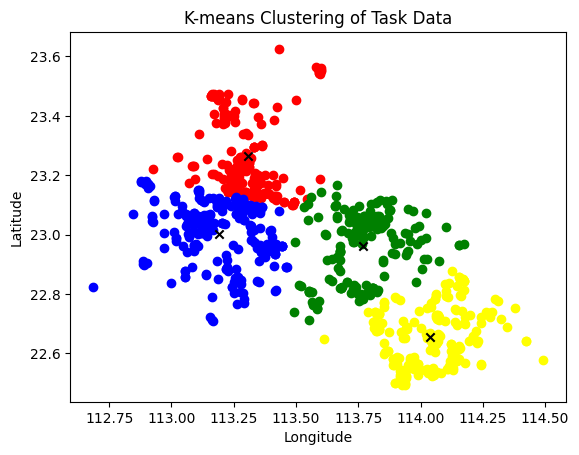

In [31]:
df
# 对df的两列数据构成的数据点进行k-means聚类分析

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
data = df[['任务gps经度', '任务gps 纬度']]
data = scaler.fit_transform(data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(data)

centers = kmeans.cluster_centers_
# Inverse transform the cluster centers to the original scale
centers = scaler.inverse_transform(centers)
print(centers)

# Plot the clusters
fig, ax = plt.subplots()
colors = ['red', 'green', 'blue', 'yellow']
for i in range(4):
    points = df[df['cluster'] == i]
    ax.scatter(points['任务gps经度'], points['任务gps 纬度'], c=colors[i])
    ax.scatter(centers[i][0], centers[i][1], c='black', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Task Data')
plt.show()



In [ ]:
S8vn0ozKJn4N

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import kstest
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.special import inv_boxcox

def KsNormDetect(df, column):
    # 计算均值
    u = df[column].mean()
    # 计算标准差
    std = df[column].std()
    # 计算P值
    print(kstest(df[column], 'norm', (u, std)))
    res = kstest(df[column], 'norm', (u, std))[1]
    print(f'{column} 均值为：{u:.2f}，标准差为：{std:.2f}')
    # 判断p值是否服从正态分布，p<=0.05 拒绝原假设 不服从正态分布
    if res <= 0.05:
        print(f'{column} 数据不服从正态分布')
        print("-" * 66)
        return True
    else:
        print(f'{column} 数据服从正态分布')
        return False

def OutlierDetection(df, column, ks_res):
    # 计算均值
    u = df[column].mean()
    # 计算标准差
    std = df[column].std()
    if ks_res:
        # 定义3σ法则识别异常值
        outliers = df[np.abs(df[column] - u) > 3 * std]
        # 剔除异常值，保留正常的数据
        clean_data = df[np.abs(df[column] - u) <= 3 * std]
        # 返回异常值和剔除异常值后的数据
        return outliers, clean_data
    else:
        print('请先检测数据是否服从正态分布')
        return None

if __name__ == '__main__':
    # 读取数据
    df = pd.read_excel('附件一：已结束项目任务数据.xls')    

    columns_to_check = ['任务gps 纬度', '任务gps经度']

    for column in columns_to_check:
        print(f"处理 {column}:")
        print("-" * 66)
        
        # 保存原始数据
        original_data = df[column].copy()
        
        # box-cox变换
        lam = boxcox_normmax(df[column] + 1)
        df[column] = boxcox1p(df[column], lam)
        
        # K-S检验
        ks_res = KsNormDetect(df, column)
        
        outliers, clean_data = OutlierDetection(df, column, ks_res)
        
        if outliers is not None and clean_data is not None:
            # 异常值和剔除异常值后的数据
            outliers[column] = inv_boxcox(outliers[column], lam) - 1
            clean_data[column] = inv_boxcox(clean_data[column], lam) - 1
            
            print("异常值:")
            print(outliers)
            print("-" * 66)
            print("清洗后的数据:")
            print(clean_data)
        
        # 恢复原始数据
        df[column] = original_data
        
        print("\n")

处理 任务gps 纬度:
------------------------------------------------------------------
KstestResult(statistic=0.06553540096313909, pvalue=0.0014619140413419125, statistic_location=0.74178397710686, statistic_sign=-1)
任务gps 纬度 均值为：0.74，标准差为：0.00
任务gps 纬度 数据不服从正态分布
------------------------------------------------------------------
异常值:
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
296  A0297  23.878398  113.539711  70.0       1
302  A0303  23.816108  113.957929  75.0       1
------------------------------------------------------------------
清洗后的数据:
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113.980837  66.0       0
1    A0002  22.686205  113.940525  65.5       0
2    A0003  22.576512  113.957198  65.5       1
3    A0004  22.564841  114.244571  75.0       0
4    A0005  22.558888  113.950723  65.5       0
..     ...        ...         ...   ...     ...
830  A0831  23.044062  113.125784  65.5       0
831  A0832  22.833262  113.280152  72.0       1
832  A0833  22.81467

/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/139145648.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers[column] = inv_boxcox(outliers[column], lam) - 1
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/139145648.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[column] = inv_boxcox(clean_data[column], lam) - 1
/opt/anaconda3/envs/pyTorchgpuEnv/lib/python3.12/site-packages/scipy/stats/_morestats.py:1317: ConstantInputWarning: An input array is con

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [14]:
import numpy as np
from scipy import stats

def process_column(df, column):
    print(f"\n处理 {column}:")
    print("-" * 66)
    
    # Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.kstest(df[column], 'norm')
    print(f"KS test result: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")
    
    # Calculate mean and standard deviation
    mean = df[column].mean()
    std = df[column].std()
    print(f"{column} 均值为：{mean:.2f}，标准差为：{std:.2f}")
    
    if p_value < 0.05:
        print(f"{column} 数据不服从正态分布")
    else:
        print(f"{column} 数据服从正态分布")
    
    # Identify outliers using z-score
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > 3]
    
    print("-" * 66)
    print("异常值:")
    print(outliers)
    
    # Remove outliers
    clean_data = df[z_scores <= 3]
    
    print("-" * 66)
    print("清洗后的数据:")
    print(clean_data)
    
    return clean_data

# Process the "任务gps经度" column
clean_data = process_column(df, "任务gps经度")


处理 任务gps经度:
------------------------------------------------------------------
KS test result: statistic=1.0000, p-value=0.0000
任务gps经度 均值为：113.54，标准差为：0.37
任务gps经度 数据不服从正态分布
------------------------------------------------------------------
异常值:
Empty DataFrame
Columns: [任务号码, 任务gps 纬度, 任务gps经度, 任务标价, 任务执行情况]
Index: []
------------------------------------------------------------------
清洗后的数据:
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113.980837  66.0       0
1    A0002  22.686205  113.940525  65.5       0
2    A0003  22.576512  113.957198  65.5       1
3    A0004  22.564841  114.244571  75.0       0
4    A0005  22.558888  113.950723  65.5       0
..     ...        ...         ...   ...     ...
830  A0831  23.044062  113.125784  65.5       0
831  A0832  22.833262  113.280152  72.0       1
832  A0833  22.814676  113.827731  85.0       1
833  A0834  23.063674  113.771188  65.5       1
834  A0835  23.123294  113.110382  85.0       1

[835 rows x 5 columns]



处理 任务gps 纬度:
------------------------------------------------------------------
KS test result: statistic=0.5006, p-value=0.0000
任务gps 纬度 均值为：0.3845，标准差为：0.1685
任务gps 纬度 数据不完全服从正态分布，但已进行初步正态化处理


/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 21153 (\N{CJK UNIFIED IDEOGRAPH-52A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6

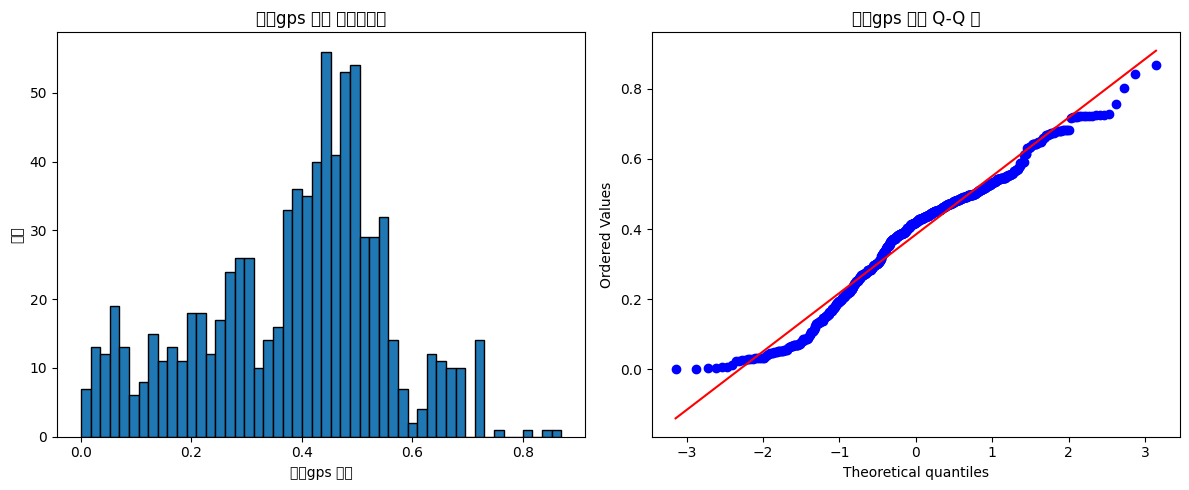

------------------------------------------------------------------
异常值:
Empty DataFrame
Columns: [任务号码, 任务gps 纬度, 任务gps经度, 任务标价, 任务执行情况]
Index: []
------------------------------------------------------------------
清洗后的数据:
      任务号码  任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  0.070514  113.980837  66.0       0
1    A0002  0.176574  113.940525  65.5       0
2    A0003  0.080131  113.957198  65.5       1
3    A0004  0.069300  114.244571  75.0       0
4    A0005  0.063730  113.950723  65.5       0
..     ...       ...         ...   ...     ...
830  A0831  0.438887  113.125784  65.5       0
831  A0832  0.292803  113.280152  72.0       1
832  A0833  0.278838  113.827731  85.0       1
833  A0834  0.451452  113.771188  65.5       1
834  A0835  0.488710  113.110382  85.0       1

[835 rows x 5 columns]

处理 任务gps经度:
------------------------------------------------------------------
KS test result: statistic=0.5787, p-value=0.0000
任务gps经度 均值为：0.5974，标准差为：0.2007
任务gps经度 数据不完全服从正态分布，但已进行初步正态化处

/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 21153 (\N{CJK UNIFIED IDEOGRAPH-52A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_46798/329012218.py:40: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/f_/zgh1n7tj6

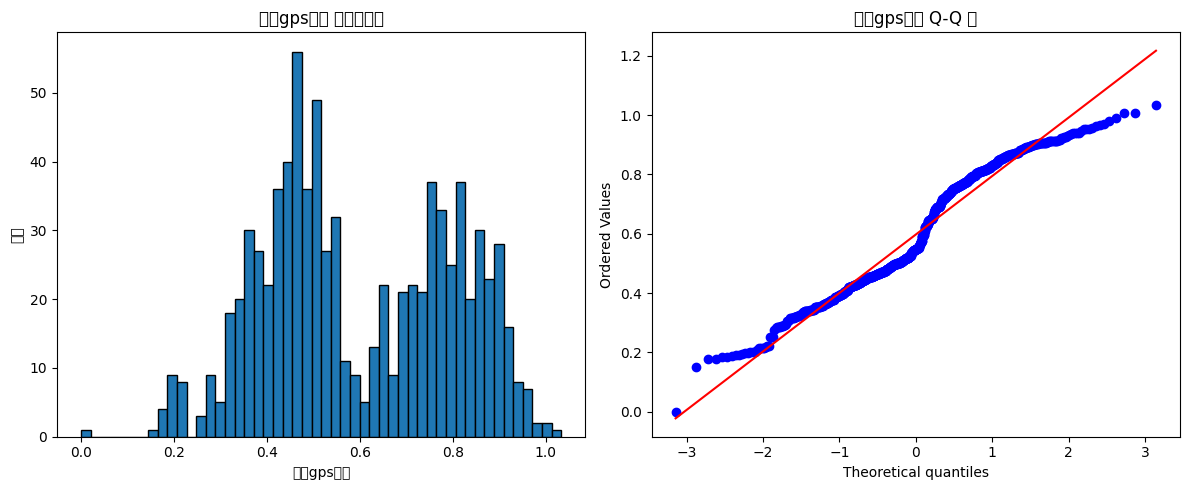

------------------------------------------------------------------
异常值:
Empty DataFrame
Columns: [任务号码, 任务gps 纬度, 任务gps经度, 任务标价, 任务执行情况]
Index: []
------------------------------------------------------------------
清洗后的数据:
      任务号码  任务gps 纬度   任务gps经度  任务标价  任务执行情况
0    A0001  0.073059  0.831856  66.0       0
1    A0002  0.193122  0.814155  65.5       0
2    A0003  0.083429  0.821514  65.5       1
3    A0004  0.071758  0.940520  75.0       0
4    A0005  0.065805  0.818662  65.5       0
..     ...       ...       ...   ...     ...
830  A0831  0.550979  0.366396  65.5       0
831  A0832  0.340179  0.468060  72.0       1
832  A0833  0.321593  0.762894  85.0       1
833  A0834  0.570591  0.736173  65.5       1
834  A0835  0.630211  0.355661  85.0       1

[835 rows x 5 columns]

最终清洗后的数据:
      任务号码  任务gps 纬度   任务gps经度  任务标价  任务执行情况
0    A0001  0.073059  1.297578  66.0       0
1    A0002  0.193122  1.257267  65.5       0
2    A0003  0.083429  1.273940  65.5       1
3    A0004  0.071758  1

In [15]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def process_geo_column(df, column):
    print(f"\n处理 {column}:")
    print("-" * 66)
    
    # 对数变换
    df[column] = np.log1p(df[column] - df[column].min())
    
    # Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.kstest(df[column], 'norm')
    print(f"KS test result: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")
    
    # Calculate mean and standard deviation
    mean = df[column].mean()
    std = df[column].std()
    print(f"{column} 均值为：{mean:.4f}，标准差为：{std:.4f}")
    
    if p_value < 0.05:
        print(f"{column} 数据不完全服从正态分布，但已进行初步正态化处理")
    else:
        print(f"{column} 数据近似服从正态分布")
    
    # 绘制直方图和QQ图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 直方图
    ax1.hist(df[column], bins=50, edgecolor='black')
    ax1.set_title(f'{column} 分布直方图')
    ax1.set_xlabel(column)
    ax1.set_ylabel('频率')
    
    # QQ图
    stats.probplot(df[column], dist="norm", plot=ax2)
    ax2.set_title(f'{column} Q-Q 图')
    
    plt.tight_layout()
    plt.show()
    
    # Identify outliers using z-score
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > 3]
    
    print("-" * 66)
    print("异常值:")
    print(outliers)
    
    # Remove outliers
    clean_data = df[z_scores <= 3]
    
    print("-" * 66)
    print("清洗后的数据:")
    print(clean_data)
    
    # 将数据转换回原始尺度
    clean_data[column] = np.expm1(clean_data[column]) + df[column].min()
    
    return clean_data

# 处理经纬度列
columns_to_process = ["任务gps 纬度", "任务gps经度"]

for column in columns_to_process:
    df_cleaned = process_geo_column(df, column)
    # 更新原始DataFrame
    df = df_cleaned

print("\n最终清洗后的数据:")
print(df)

In [6]:
# 分别将df中的任务gps 纬度和任务gps精读读取到两个numpy数组中
lat = df['任务gps 纬度'].values
lng = df['任务gps经度'].values
print(lat)
print(lng)

[22.56614225 22.68620526 22.57651183 22.56484081 22.55888775 22.55899906
 22.54900371 22.56277351 22.50001192 22.5437861  22.52486369 22.519087
 22.54797243 22.50616871 22.49962566 22.54032142 22.52455419 22.4981901
 22.54603946 22.49772892 22.49416247 22.51592012 22.51578568 22.54220963
 22.54458961 22.49308313 22.52488949 22.54808582 22.56470734 22.58193448
 22.54293611 22.52394954 22.55101305 22.5829933  22.54927013 22.52596134
 22.7563793  22.64144071 22.71166007 22.60649323 22.66229971 22.63539828
 22.73802844 22.62558348 22.65265496 22.78892197 22.70103564 22.63154051
 22.6417148  22.68940336 22.63010042 22.66391673 22.750664   22.72272561
 22.64138032 22.77640754 22.58706534 22.69339571 22.6040497  22.6376364
 22.65788521 22.61781817 22.64144071 22.78139876 22.72294122 22.67470711
 22.66283814 22.65776972 22.65691327 22.73859039 22.71636331 22.52331401
 22.65301422 22.5331754  22.59955905 22.65027837 22.73782038 22.73859039
 22.74300109 22.63495417 22.75139338 22.61556463 22.684

In [ ]:
# 对这两个


In [6]:
def KsNormDetect(df):
    # 计算均值
    u = df['value'].mean()
    # 计算标准差
    std = df['value'].std()
    # 计算P值
    print(kstest(df['value'], 'norm', (u, std)))
    res = kstest(df['value'], 'norm', (u, std))[1]
    print('均值为：%.2f，标准差为：%.2f' % (u, std))
    # 判断p值是否服从正态分布，p<=0.05 拒绝原假设 不服从正态分布
    if res <= 0.05:
        print('该列数据不服从正态分布')
        print("-" * 66)
        return True
    else:
        print('该列数据服从正态分布')
        return False
def OutlierDetection(df, ks_res):
    # 计算均值
    u = df['value'].mean()
    # 计算标准差
    std = df['value'].std()
    if ks_res:
        # 定义3σ法则识别异常值
        outliers = df[np.abs(df['value'] - u) > 3 * std]
        # 剔除异常值，保留正常的数据
        clean_data = df[np.abs(df['value'] - u) < 3 * std]
        # 返回异常值和剔除异常值后的数据
        return outliers, clean_data

    else:
        print('请先检测数据是否服从正态分布')
        return None

In [9]:
dfs = []
outliers = []
clean_data = []

for data, name in zip([lat, lng], ['lat', 'lng']):
    df_temp = pd.DataFrame(data, columns=['value'])
    lam = boxcox_normmax(df_temp["value"] + 1)
    df_temp["value"] = boxcox1p(df_temp['value'], lam)
    ks_res = KsNormDetect(df_temp)
    outlier, clean = OutlierDetection(df_temp, ks_res)
    outliers.append(inv_boxcox(outlier, lam) - 1)
    clean_data.append(inv_boxcox(clean, lam) - 1)
    dfs.append(df_temp)

outliers_1, outliers_2 = outliers
clean_data_1, clean_data_2 = clean_data

print(outliers_1)
print(outliers_2)
print(clean_data_1)
print(clean_data_2)

KstestResult(statistic=0.06553540096313909, pvalue=0.0014619140413419125, statistic_location=0.74178397710686, statistic_sign=-1)
均值为：0.74，标准差为：0.00
该列数据不服从正态分布
------------------------------------------------------------------


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [10]:


import numpy as np
import pandas as pd
from scipy.stats import kstest
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.special import inv_boxcox
def KsNormDetect(df):
    # 计算均值
    u = df['value'].mean()
    # 计算标准差
    std = df['value'].std()
    # 计算P值
    print(kstest(df['value'], 'norm', (u, std)))
    res = kstest(df['value'], 'norm', (u, std))[1]
    print('均值为：%.2f，标准差为：%.2f' % (u, std))
    # 判断p值是否服从正态分布，p<=0.05 拒绝原假设 不服从正态分布
    if res <= 0.05:
        print('该列数据不服从正态分布')
        print("-" * 66)
        return True
    else:
        print('该列数据服从正态分布')
        return False
def OutlierDetection(df, ks_res):
    # 计算均值
    u = df['value'].mean()
    # 计算标准差
    std = df['value'].std()
    if ks_res:
        # 定义3σ法则识别异常值
        outliers = df[np.abs(df['value'] - u) > 3 * std]
        # 剔除异常值，保留正常的数据
        clean_data = df[np.abs(df['value'] - u) < 3 * std]
        # 返回异常值和剔除异常值后的数据
        return outliers, clean_data

    else:
        print('请先检测数据是否服从正态分布')
        return None
if __name__ == '__main__':
    # 构造数据  某一列数据  含有异常值
    data = np.random.normal(60, 5, 200)
    data[6], data[66], data[196] = 16, 360, 180
    print(data)
    
    print("-" * 66)
    # 可以转换为pandas的DataFrame 便于调用方法计算均值和标准差
    df = pd.DataFrame(data, columns=['value'])
    # box-cox变换
    lam = boxcox_normmax(df["value"] + 1)
    df["value"] = boxcox1p(df['value'], lam)
    # K-S检验
    ks_res = KsNormDetect(df)
    outliers, clean_data = OutlierDetection(df, ks_res)
    # 异常值和剔除异常值后的数据
    outliers = inv_boxcox(outliers, lam) - 1
    clean_data = inv_boxcox(clean_data, lam) - 1
    print(outliers)
    print("-" * 66)
    print(clean_data)



[ 51.66849686  61.78996141  56.81996018  66.54138989  57.33372209
  60.78698145  16.          62.83538137  61.61808451  56.08498387
  52.79040928  64.21143183  49.90037823  54.81989     68.77272418
  57.538824    62.47898824  48.13634309  52.53219058  57.5131381
  59.43441571  63.46930573  57.01155986  56.5930001   64.74358899
  61.22459106  60.63459399  65.03074051  61.68568252  56.64190118
  67.10581125  51.52636984  57.1072766   59.2704791   57.9687236
  56.45921053  67.6501998   56.85032147  63.5521753   64.00792709
  62.63594564  58.60837541  55.50345089  66.71025117  52.53152726
  56.47191299  61.23045458  64.33394241  60.11802888  55.73177083
  57.86377173  60.01268735  47.19970742  67.07304669  56.86676682
  57.63322237  63.59892787  59.50116903  63.8666343   52.236803
  58.63067421  59.39367237  62.55456219  60.02761774  56.76676802
  64.80712009 360.          69.12741315  58.69801967  57.33301806
  62.25729628  65.34965397  55.45471267  53.15351744  58.27336038
  61.48773651 

In [11]:
import math
import pandas as pd

import matplotlib.pyplot as plt

# generate random num tested
src_data_1 = pd.read_excel('附件一：已结束项目任务数据.xls', sheet_name=0, header=0)  # 第一张表格，第一行为列名
src_data_2 = pd.read_excel('附件一：已结束项目任务数据.xls', sheet_name=0, header=0)  # 第一张表格，第一行为列名

# src_data_1 = df['任务gps 纬度'].values
# src_data_2 = df['任务gps经度'].values

mean_1 = src_data_1['任务gps 纬度'].mean()
std_1 = src_data_2['任务gps经度'].std()

mean_2 = src_data_2['任务gps 纬度'].mean()
std_2 = src_data_2['任务gps经度'].std()

drop_indices_1 = []
drop_indices_2 = []

for index, row in src_data_1.iterrows():
    tmp = (row - mean_1).abs() > 3 * std_1
    if tmp.any():
        drop_indices_1.append(index)

for index, row in src_data_2.iterrows():
    tmp = (row - mean_2).abs() > 3 * std_2
    if tmp.any():
        drop_indices_2.append(index)

dst_data_1 = src_data_1.drop(drop_indices_1)
dst_data_2 = src_data_2.drop(drop_indices_2)

writer = pd.ExcelWriter('处理后的结果.xlsx')
dst_data_1.to_excel(writer, 'page_1')
dst_data_2.to_excel(writer, 'page_2')
writer.save()



TypeError: unsupported operand type(s) for -: 'str' and 'float'